In [ ]:
import os
import math
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
df = pd.read_parquet('/kaggle/input/dl-tier/normalised_data.parquet')
df

,time,total_amount,mean_amount,mean_fare_amount,passenger_count,mean_passenger_per_trip,total_trip_distance,mean_trip_distance,number_trips
0,2011-01-01 00:00:00,0.241932,0.084480,0.205726,0.196542,1.630985,0.345569,0.257040,0.227363
1,2011-01-01 01:00:00,0.280106,0.100345,0.225582,0.219872,1.661980,0.404502,0.276820,0.249608
2,2011-01-01 02:00:00,0.252626,0.101716,0.226668,0.193952,1.632797,0.374753,0.286956,0.224117
3,2011-01-01 03:00:00,0.222074,0.102202,0.226325,0.165042,1.583062,0.343214,0.301243,0.196702
4,2011-01-01 04:00:00,0.169204,0.111931,0.238638,0.116491,1.512791,0.271299,0.325307,0.145286
...,...,...,...,...,...,...,...,...,...
113135,2023-11-30 19:00:00,0.399727,0.551558,0.515329,0.102551,1.343112,0.241533,0.287825,0.144059
113136,2023-11-30 20:00:00,0.362646,0.507927,0.510040,0.099231,1.350020,0.247325,0.308807,0.138682
113137,2023-11-30 21:00:00,0.353881,0.476736,0.480066,0.103891,1.385149,0.238547,0.289608,0.141512
113138,2023-11-30 22:00:00,0.345732,0.485349,0.489610,0.098081,1.355396,0.247708,0.314880,0.136531


In [ ]:
class DateTimeEncoder:
    def __init__(self):
        self.date_mapping = {}
        self.day_mapping = {}
        self.month_mapping = {}
        self.hour_mapping = {}

    def fit(self, datetime_column):
        # Create a mapping of datetime values to ordinal numbers
        unique_dates = sorted(datetime_column.dt.date.unique())
        unique_days = sorted(datetime_column.dt.day.unique())
        unique_months = sorted(datetime_column.dt.month.unique())
        unique_hours = sorted(datetime_column.dt.hour.unique())

        self.date_mapping = {date: i+1 for i, date in enumerate(unique_dates)}
        self.day_mapping = {day: i+1 for i, day in enumerate(unique_days)}
        self.month_mapping = {month: i+1 for i, month in enumerate(unique_months)}
        self.hour_mapping = {hour: i+1 for i, hour in enumerate(unique_hours)}

    def transform(self, datetime_column):
        # Transform datetime values to ordinal numbers using the mapping
        encoded_date = datetime_column.dt.date.map(self.date_mapping)
        encoded_day = datetime_column.dt.day.map(self.day_mapping)
        encoded_month = datetime_column.dt.month.map(self.month_mapping)
        encoded_hour = datetime_column.dt.hour.map(self.hour_mapping)
        return encoded_date, encoded_day, encoded_month, encoded_hour

    def inverse_transform(self, encoded_date, encoded_day, encoded_month, encoded_hour):
        # Retrieve the original datetime values from the encoded numbers
        decoded_date = encoded_date.map({v: k for k, v in self.date_mapping.items()})
        decoded_day = encoded_day.map({v: k for k, v in self.day_mapping.items()})
        decoded_month = encoded_month.map({v: k for k, v in self.month_mapping.items()})
        decoded_hour = encoded_hour.map({v: k for k, v in self.hour_mapping.items()})
        return decoded_date, decoded_day, decoded_month, decoded_hour


In [ ]:
# Initialize and fit the encoder
encoder = DateTimeEncoder()
encoder.fit(df['time'])

# Encode datetime values
df['encoded_date'], df['day'], df['month'], df['hour'] = encoder.transform(df['time'])
# Decode ordinal numbers back to datetime values
# decoded_date, decoded_day, decoded_month = encoder.inverse_transform(encoded_date, encoded_day, encoded_month)


In [ ]:
data = df.drop(['time'], axis=1)
data

,total_amount,mean_amount,mean_fare_amount,passenger_count,mean_passenger_per_trip,total_trip_distance,mean_trip_distance,number_trips,encoded_date,day,month,hour
0,0.241932,0.084480,0.205726,0.196542,1.630985,0.345569,0.257040,0.227363,1,1,1,1
1,0.280106,0.100345,0.225582,0.219872,1.661980,0.404502,0.276820,0.249608,1,1,1,2
2,0.252626,0.101716,0.226668,0.193952,1.632797,0.374753,0.286956,0.224117,1,1,1,3
3,0.222074,0.102202,0.226325,0.165042,1.583062,0.343214,0.301243,0.196702,1,1,1,4
4,0.169204,0.111931,0.238638,0.116491,1.512791,0.271299,0.325307,0.145286,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
113135,0.399727,0.551558,0.515329,0.102551,1.343112,0.241533,0.287825,0.144059,4717,30,11,20
113136,0.362646,0.507927,0.510040,0.099231,1.350020,0.247325,0.308807,0.138682,4717,30,11,21
113137,0.353881,0.476736,0.480066,0.103891,1.385149,0.238547,0.289608,0.141512,4717,30,11,22
113138,0.345732,0.485349,0.489610,0.098081,1.355396,0.247708,0.314880,0.136531,4717,30,11,23


In [ ]:
ratio = (data.number_trips.max()-data.number_trips.min())**2

In [ ]:
# Assuming you have a DataFrame called 'df'
# Save DataFrame to CSV
data.to_csv('data_with_datetime_features_used_as_condition.csv', index=False)  # Specify the file path and set index=False if you don't want to save the index

# Download CSV file from Kaggle Notebook
from IPython.display import FileLink
FileLink('data_with_datetime_features_used_as_condition.csv')  # This will create a download link for the CSV file


/kaggle/working/data_with_datetime_features_used_as_condition.csv

In [ ]:
def unnormalize_data(df, column, max_value):
        df[column] = df[column] * (max_value - df[column].min()) + df[column].min()
        return df[column]

max_values = [600*1e3,50,35,100*1e3,100*1e3,10,53*1e3]

In [ ]:
# Group the data by date and aggregate the values
daily_data = df.groupby('encoded_date').agg({
    'total_amount': 'sum',
    'mean_amount': 'mean',
    'mean_fare_amount': 'mean',
    'passenger_count': 'mean',
    'mean_passenger_per_trip': 'mean',
    'total_trip_distance': 'sum',
    'mean_trip_distance': 'mean',
    'number_trips': 'sum'
}).reset_index()
daily_data['number_trips'] = unnormalize_data(daily_data, 'number_trips', 53*1e3)
# Plot day-wise number of trip records
fig = px.bar(daily_data, x='encoded_date', y='number_trips', title='Number of Trip Records per Day')
fig.update_xaxes(title='Encoded Date')
fig.update_yaxes(title='Number of Trip Records')
fig.show()


In [ ]:
# Group the data by month and aggregate the values
monthly_data = df.groupby('month').agg({
    'total_amount': 'sum',
    'mean_amount': 'mean',
    'mean_fare_amount': 'mean',
    'passenger_count': 'mean',
    'mean_passenger_per_trip': 'mean',
    'total_trip_distance': 'sum',
    'mean_trip_distance': 'mean',
    'number_trips': 'sum'
}).reset_index()
monthly_data['number_trips'] = unnormalize_data(monthly_data, 'number_trips', 53*1e3)

# Plot month-wise number of trip records
fig = px.bar(monthly_data, x='month', y='number_trips', title='Number of Trip Records per Month')
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Number of Trip Records')
fig.show()


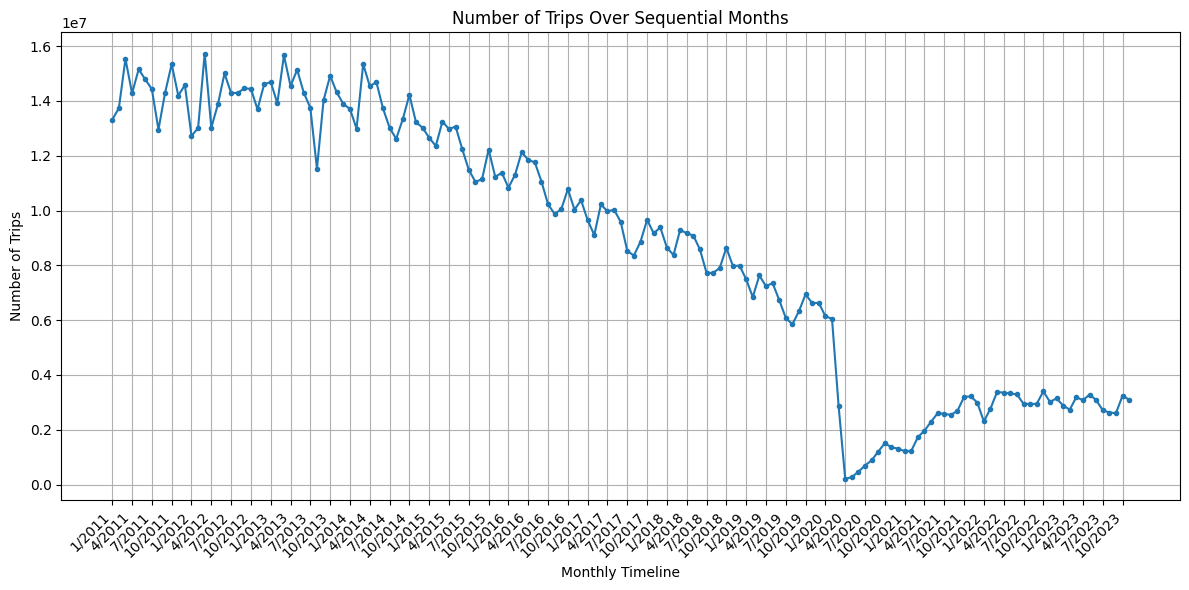

In [ ]:
def aggregate_data_over_sequential_months(df):
    # Extract month and year from the datetime column
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    # Group the data by month and year, and aggregate the values
    monthly_data = df.groupby(['year', 'month']).agg({
        'total_amount': 'sum',
        'mean_amount': 'mean',
        'mean_fare_amount': 'mean',
        'passenger_count': 'mean',
        'mean_passenger_per_trip': 'mean',
        'total_trip_distance': 'mean',
        'mean_trip_distance': 'mean',
        'number_trips': 'sum'
    }).reset_index()

    return monthly_data

# Call the function to get the aggregated dataset
sequential_monthly_aggregated_data = aggregate_data_over_sequential_months(df)
sequential_monthly_aggregated_data

timeline = []
for year in range(2011,2024):
    for month in range(1,13):
        timeline.append(f"{str(month)}/{str(year)}")

import matplotlib.pyplot as plt

# Plot the aggregated data
plt.figure(figsize=(12, 6))
# plt.plot(timeline[:-1], sequential_monthly_aggregated_data['number_trips'], marker='.')
plt.plot(timeline[:-1], unnormalize_data(sequential_monthly_aggregated_data, 'number_trips',53*1e3), marker='.')
plt.title('Number of Trips Over Sequential Months')
plt.xlabel('Monthly Timeline')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.xticks(timeline[:-1][::3], rotation=45, ha='right')  # Display every 3rd tick label and rotate
plt.tight_layout()
plt.show()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113140 entries, 0 to 113139
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   total_amount             113140 non-null  float64
 1   mean_amount              113140 non-null  float64
 2   mean_fare_amount         113140 non-null  float64
 3   passenger_count          113140 non-null  float64
 4   mean_passenger_per_trip  113140 non-null  float64
 5   total_trip_distance      113140 non-null  float64
 6   mean_trip_distance       113140 non-null  float64
 7   number_trips             113140 non-null  float64
 8   encoded_date             113140 non-null  int64  
 9   day                      113140 non-null  int64  
 10  month                    113140 non-null  int64  
 11  hour                     113140 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 10.4 MB


In [ ]:
lstm_data = data.iloc[:,:7]
output_data = data.iloc[:,7]
condition_data=data.iloc[:,8:]
lstm_data.info(), output_data.info(), condition_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113140 entries, 0 to 113139
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   total_amount             113140 non-null  float64
 1   mean_amount              113140 non-null  float64
 2   mean_fare_amount         113140 non-null  float64
 3   passenger_count          113140 non-null  float64
 4   mean_passenger_per_trip  113140 non-null  float64
 5   total_trip_distance      113140 non-null  float64
 6   mean_trip_distance       113140 non-null  float64
dtypes: float64(7)
memory usage: 6.0 MB
<class 'pandas.core.series.Series'>
RangeIndex: 113140 entries, 0 to 113139
Series name: number_trips
Non-Null Count   Dtype  
--------------   -----  
113140 non-null  float64
dtypes: float64(1)
memory usage: 884.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113140 entries, 0 to 113139
Data columns (total 4 columns):
 #   Column        Non-Nul

(None, None, None)

In [ ]:
# Define a function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return sequences

# Define custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data_input, data_condition, data_output, input_seq_length, output_seq_length):
        self.sequences_output = create_sequences(data_output, output_seq_length)
        self.sequences_input = create_sequences(data_input, input_seq_length)[:len(self.sequences_output)]
        self.sequences_condition = create_sequences(data_condition, input_seq_length)[:len(self.sequences_output)]

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, idx):
        return (torch.tensor(self.sequences_input[idx], dtype=torch.float32), torch.tensor(self.sequences_condition[idx], dtype=torch.float32), \
        torch.tensor(self.sequences_output[idx], dtype=torch.float32))



In [ ]:
input_seq_length = 24*7  # Set the input sequence length
output_seq_length = 24
dataset = TimeSeriesDataset(lstm_data.values,condition_data.values, output_data.values[168:], input_seq_length, output_seq_length)

In [ ]:
for i,c,o in dataset:
  print(i.shape, c.shape, o.shape)
  break


torch.Size([168, 7]) torch.Size([168, 4]) torch.Size([24])


In [ ]:
train_dataset = dataset[:-30*24]
test_dataset = dataset[-30*24:]
train_dataset = list(zip(*train_dataset)) #transpose (3,n) tuple to (n,3)
test_dataset = list(zip(*test_dataset))

/tmp/ipykernel_34/4250389344.py:20: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)



In [ ]:
# Convert train dataset to DataLoader
train_loader = DataLoader(train_dataset, batch_size=64)

# # Convert test dataset to DataLoader
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
# #creating 1 batch shifted val_loader
# idx=0
# val_loader = []
# for i,c,o in train_loader:
#     if idx!=0:
#         val_loader.append([i,c,o])
#     idx+=1
# idx=0
# for i,c,o in test_loader:
#     if idx!=0:
#         break
#     val_loader.append([i,c,o])
#     idx=+1

# len(val_loader), len(train_loader)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, condition_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.condition_size = condition_size
        self.output_size = output_size

        # LSTM layers for input sequence and condition sequence
        self.lstm_input = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm_condition = nn.LSTM(condition_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to predict next n sequences
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input_seq, condition_seq):
        batch_size = input_seq.size(0)

        # Initial hidden and cell states for input sequence LSTM
        h0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)
        c0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)

        # LSTM forward pass for input sequence
        lstm_out_input, _ = self.lstm_input(input_seq, (h0_input, c0_input))

        # Initial hidden and cell states for condition sequence LSTM
        h0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)
        c0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)

        # LSTM forward pass for condition sequence
        lstm_out_condition, _ = self.lstm_condition(condition_seq, (h0_condition, c0_condition))

        # Take the last element of LSTM output sequences
        lstm_out_input_last = lstm_out_input[:, -1, :]
        lstm_out_condition_last = lstm_out_condition[:, -1, :]
        # Concatenate LSTM outputs
        combined = torch.cat((lstm_out_input_last, lstm_out_condition_last), dim=1)
        # Fully connected layer for predicting next n sequences
        fc_output = self.fc(combined)

        return fc_output


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, condition_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.condition_size = condition_size
        self.output_size = output_size

        # RNN layers for input sequence and condition sequence
        self.rnn_input = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn_condition = nn.RNN(condition_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to predict next n sequences
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input_seq, condition_seq):
        batch_size = input_seq.size(0)

        # Initial hidden states for input sequence RNN
        h0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)

        # RNN forward pass for input sequence
        rnn_out_input, _ = self.rnn_input(input_seq, h0_input)

        # Initial hidden states for condition sequence RNN
        h0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)

        # RNN forward pass for condition sequence
        rnn_out_condition, _ = self.rnn_condition(condition_seq, h0_condition)

        # Take the last element of RNN output sequences
        rnn_out_input_last = rnn_out_input[:, -1, :]
        rnn_out_condition_last = rnn_out_condition[:, -1, :]

        # Concatenate RNN outputs
        combined = torch.cat((rnn_out_input_last, rnn_out_condition_last), dim=1)

        # Fully connected layer for predicting next n sequences
        fc_output = self.fc(combined)

        return fc_output


In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, condition_size, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.condition_size = condition_size
        self.output_size = output_size

        # GRU layers for input sequence and condition sequence
        self.gru_input = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.gru_condition = nn.GRU(condition_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to predict next n sequences
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input_seq, condition_seq):
        batch_size = input_seq.size(0)

        # Initial hidden states for input sequence GRU
        h0_input = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)

        # GRU forward pass for input sequence
        gru_out_input, _ = self.gru_input(input_seq, h0_input)

        # Initial hidden states for condition sequence GRU
        h0_condition = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(condition_seq.device)

        # GRU forward pass for condition sequence
        gru_out_condition, _ = self.gru_condition(condition_seq, h0_condition)

        # Take the last element of GRU output sequences
        gru_out_input_last = gru_out_input[:, -1, :]
        gru_out_condition_last = gru_out_condition[:, -1, :]

        # Concatenate GRU outputs
        combined = torch.cat((gru_out_input_last, gru_out_condition_last), dim=1)

        # Fully connected layer for predicting next n sequences
        fc_output = self.fc(combined)

        return fc_output


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train(model, train_loader, num_epochs, optimizer, loss_fn, model_name, device=device, plot=True):
  training_loss = []
  model.train()  # Set the model to training mode
  # Training loop
  for epoch in range(num_epochs):
      total_loss = 0.0
      for input_seq, condition_seq, target_seq in train_loader:
          input_seq, condition_seq, target_seq = input_seq.to(device), condition_seq.to(device), target_seq.to(device)
          optimizer.zero_grad()  # Clear gradients
          # Forward pass
          fc_output = model(input_seq, condition_seq)
          # Calculate loss
          loss = loss_fn(target_seq, fc_output)
          total_loss += loss.item()
          # Backward pass
          loss.backward()
          optimizer.step()  # Update weights
      training_loss.append(total_loss / len(train_loader))
      print(f"Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader)}")

  # Plot actual vs predicted number of trips
  plt.figure(figsize=(10, 6))
  plt.plot(training_loss, color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'{model_name} Training Loss over {num_epochs} epochs')
  plt.show()
  return training_loss



In [ ]:
def test(model, test_loader):
  # Testing loop
  model.eval()
  with torch.no_grad():
      test_loss = 0.0
      predictions = []
      for input_seq, condition_seq, target_seq in test_loader:
          input_seq, condition_seq, target_seq = input_seq.to(device), condition_seq.to(device), target_seq.to(device)
          # Forward pass
          output = model(input_seq, condition_seq)
          # Append the predicted values
          predictions.append(output[:,-1].cpu().numpy())  # Convert predictions to numpy array
          # Calculate loss
          loss = nn.MSELoss()(target_seq, output)
          test_loss += loss.item()
      print(f"Test Loss: {test_loss / len(test_loader)}")
      return predictions,test_loss / len(test_loader)

In [ ]:
def plot_test_results(predictions, model_name):
  # Combine all predictions into a single numpy array
  predictions = np.concatenate(predictions, axis=0)
  # Convert target_seq to numpy array
  actual_values = np.concatenate([target_seq[:,-1].cpu().numpy() for _, _, target_seq in test_loader], axis=0)
  predictions = predictions * (53*1e3 -output_data.min()) + output_data.min()
  actual_values = (output_data * (53*1e3 - output_data.min()) + output_data.min())

  # Plot actual vs predicted number of trips
  plt.figure(figsize=(10, 6))
  plt.plot(actual_values.index[-1000:-720], actual_values[-1000:-720], label='Actual Number of Trips (Training)', color='black')
  plt.plot(actual_values.index[-720:], actual_values[-720:], label='Actual Number of Trips (Testing)', color='green')
  plt.plot(actual_values.index[-720:], predictions, label='Predicted Number of Trips', color='red')
  plt.xlabel('Time Steps')
  plt.ylabel('Number of Trips')
  plt.title(f'Actual vs Predicted Number of Trips upon {model_name}')
  plt.legend()
  plt.show()


In [ ]:
input_size = 7
hidden_size = 128
num_layers = 2
condition_size = 4
output_size = 24
num_epochs = 10

Epoch 1, Training Loss: 0.011708100764219267
Epoch 2, Training Loss: 0.004098710534907008
Epoch 3, Training Loss: 0.0032970970461814798
Epoch 4, Training Loss: 0.002850047595505907
Epoch 5, Training Loss: 0.002669998994752199
Epoch 6, Training Loss: 0.0025606472712028433
Epoch 7, Training Loss: 0.002517456364088795
Epoch 8, Training Loss: 0.0026873061937835894
Epoch 9, Training Loss: 0.0021735338167265476
Epoch 10, Training Loss: 0.0021264046154246567


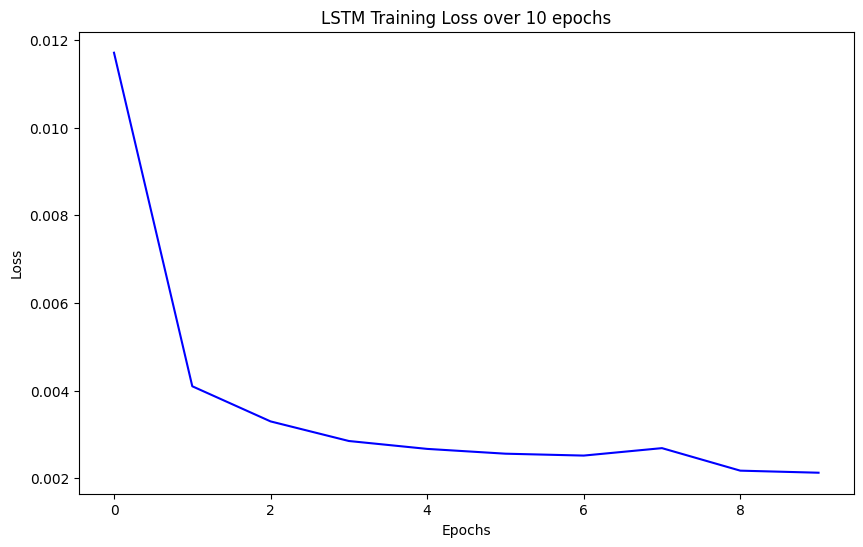

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
lstm_training_loss = train(model, train_loader, num_epochs, optimizer, loss_fn, model_name='LSTM', device=device, plot=True)

Test Loss: 0.0002782396404654719


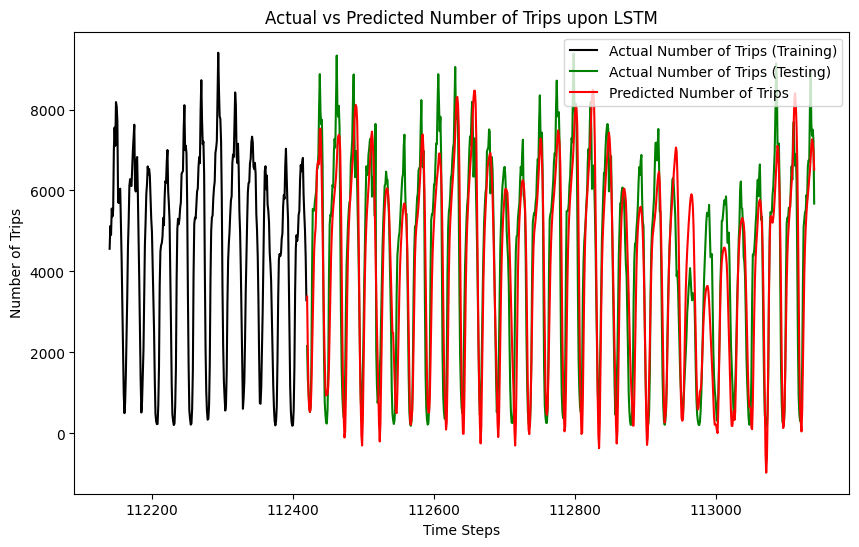

In [ ]:
# Save the model
torch.save(model.state_dict(), 'LSTM_model.pth')
predictions, _ = test(model, test_loader)
plot_test_results(predictions, model_name = 'LSTM')

Epoch 1, Training Loss: 0.007821786245860645
Epoch 2, Training Loss: 0.004302761676627725
Epoch 3, Training Loss: 0.0035487219128845855
Epoch 4, Training Loss: 0.0031769321220286124
Epoch 5, Training Loss: 0.0028508621599548974
Epoch 6, Training Loss: 0.002618276591360887
Epoch 7, Training Loss: 0.0025189690578531062
Epoch 8, Training Loss: 0.0023139488904082447
Epoch 9, Training Loss: 0.0022838462681271346
Epoch 10, Training Loss: 0.002256661285763405


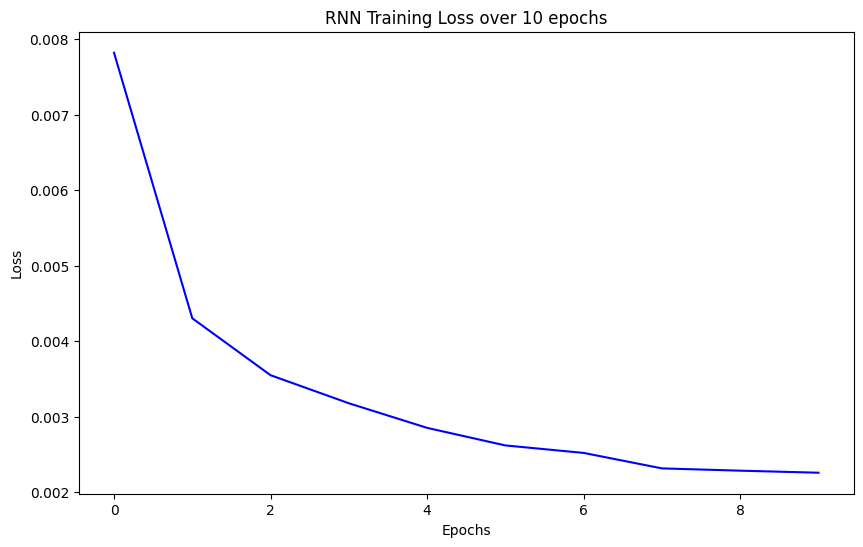

In [ ]:
model = RNN(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
rnn_training_loss = train(model, train_loader, num_epochs, optimizer, loss_fn, model_name='RNN', device=device, plot=True)

Test Loss: 0.00031992130971048027


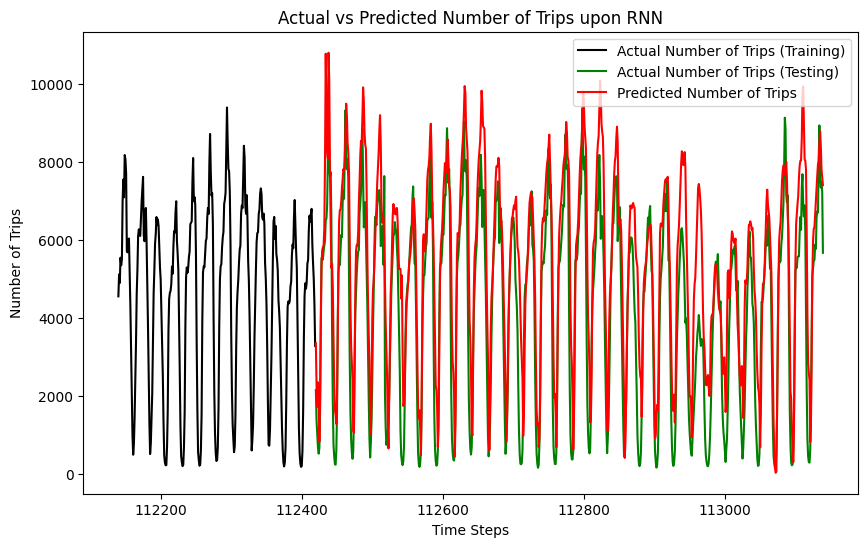

In [ ]:
# Save the model
torch.save(model.state_dict(), 'RNN_model.pth')
predictions, _ = test(model, test_loader)
plot_test_results(predictions, model_name = 'RNN')

Epoch 1, Training Loss: 0.009286287047634708
Epoch 2, Training Loss: 0.00416112291883398
Epoch 3, Training Loss: 0.0030820578684136453
Epoch 4, Training Loss: 0.0027600404565432494
Epoch 5, Training Loss: 0.0025150540620302955
Epoch 6, Training Loss: 0.002370558432731381
Epoch 7, Training Loss: 0.0022221883195733473
Epoch 8, Training Loss: 0.0021147431448116966
Epoch 9, Training Loss: 0.001998545501946543
Epoch 10, Training Loss: 0.0019068026329855502


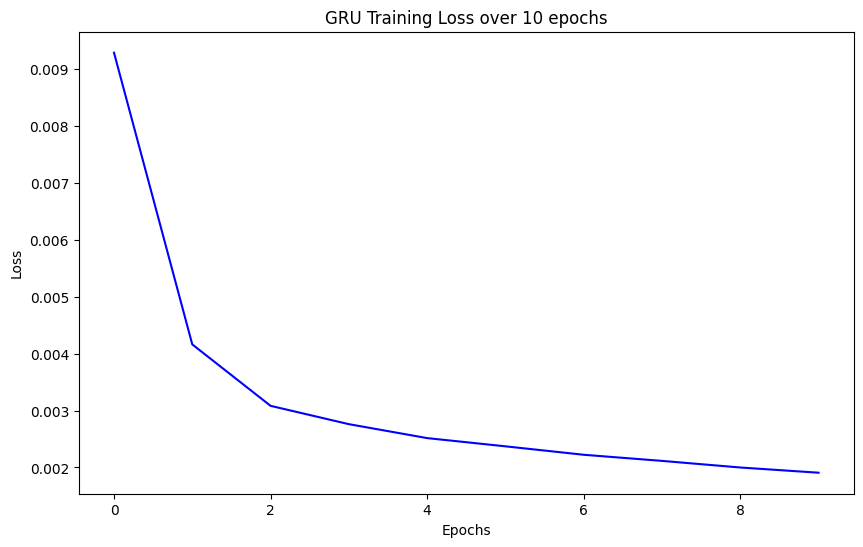

In [ ]:
model = GRU(input_size, hidden_size, num_layers, condition_size, output_size)
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
# Move model to CUDA if available
model = model.to(device)
gru_training_loss = train(model, train_loader, num_epochs, optimizer, loss_fn, model_name='GRU', device=device, plot=True)

Test Loss: 0.00025294197621406056


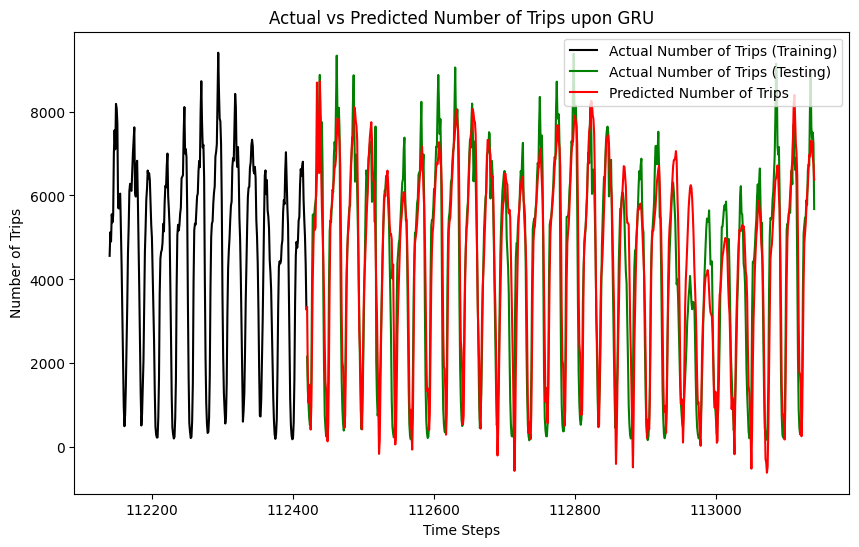

In [ ]:
# Save the model
torch.save(model.state_dict(), 'GRU_model.pth')
predictions, _ = test(model, test_loader)
plot_test_results(predictions, model_name = 'GRU')

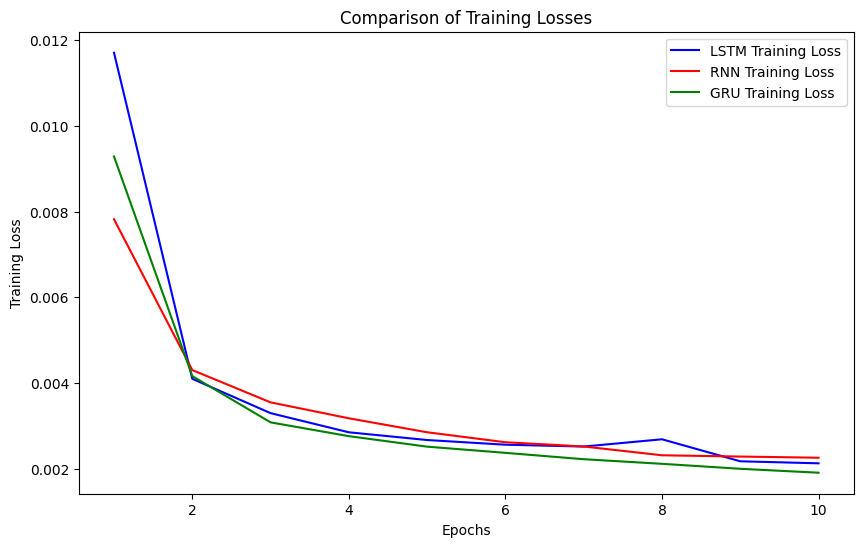

In [ ]:
# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), lstm_training_loss, label='LSTM Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), rnn_training_loss, label='RNN Training Loss', color='red')
plt.plot(range(1, num_epochs+1), gru_training_loss, label='GRU Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Comparison of Training Losses')
plt.legend()
plt.show()

Test Loss: 0.0002782396404654719
Test Loss: 0.00031992130971048027
Test Loss: 0.00025294197621406056


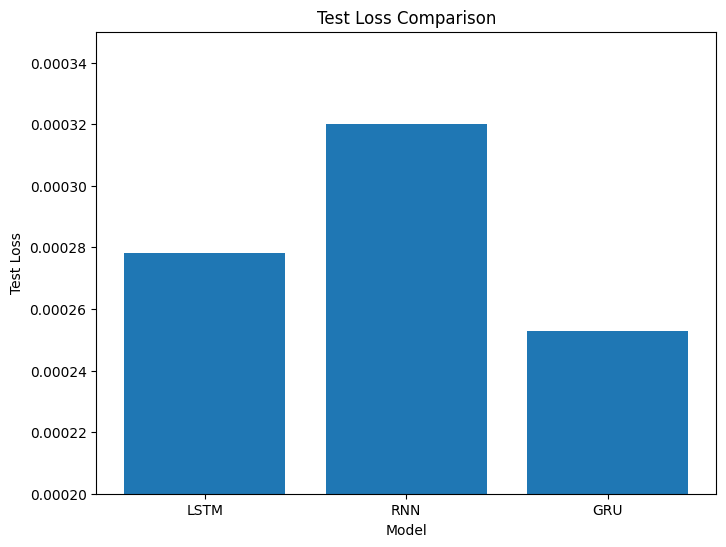

In [ ]:
lstm_model = LSTM(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('LSTM_model.pth')
lstm_model.load_state_dict(state_dict)

rnn_model = RNN(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('RNN_model.pth')
rnn_model.load_state_dict(state_dict)

gru_model = GRU(input_size, hidden_size, num_layers, condition_size, output_size).to(device)
state_dict = torch.load('GRU_model.pth')
gru_model.load_state_dict(state_dict)

_, test_loss_lstm = test(lstm_model, test_loader)
_, test_loss_rnn = test(rnn_model, test_loader)
_, test_loss_gru = test(gru_model, test_loader)

# Test losses
test_losses = [test_loss_lstm, test_loss_rnn, test_loss_gru]
models = ['LSTM', 'RNN', 'GRU']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, test_losses)
plt.xlabel('Model')
plt.ylabel('Test Loss')
# Set the y-axis limits
plt.ylim(0.00020, 0.00035)
plt.title('Test Loss Comparison')
plt.show()

**LSTM with combined data **

Epoch [10/10], Loss: 0.0054


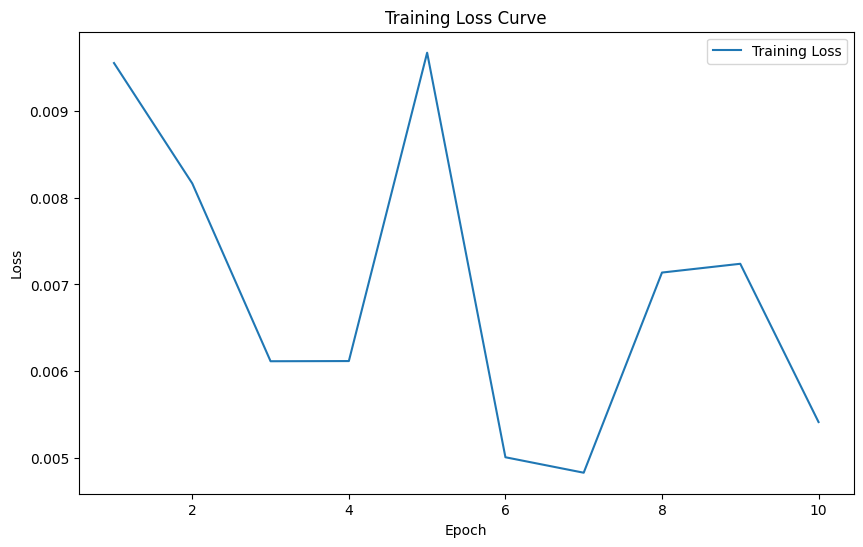

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(out[:, -1, :])
        return out, h


# Define hyperparameters
input_size = 11 # Number of features
hidden_size = 64
num_layers = 2
output_size = 24  # Output size adjusted to output 24 values for each prediction
seq_length = 24*7
learning_rate = 0.001
num_epochs = 10

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store loss values
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # Initialize epoch loss
    for input_data, condition_data, output_data in train_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        int_data = torch.concat([input_data, condition_data], axis = 2).to(device)

        output_data = output_data.to(device)
        # Forward pass
        optimizer.zero_grad()
        h = (torch.zeros(num_layers, input_data.size(0), hidden_size).to(device),
             torch.zeros(num_layers, input_data.size(0), hidden_size).to(device))
        output, _ = model(int_data, h)
        loss = criterion(output, output_data)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_data.size(0)  # Accumulate the loss for this batch

    # Calculate average epoch loss
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [ ]:
# Test the model
model.eval()
test_loss = 0.0

with torch.no_grad():
    predictions = []
    for input_data, condition_data, output_data in test_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        int_data = torch.cat([input_data, condition_data], dim=2).to(device)
        output_data = output_data.to(device)

        # Initialize hidden state with correct dimensions
        h = torch.zeros(num_layers, input_data.size(0), hidden_size).to(device)  # Corrected dimension
        c = torch.zeros(num_layers, input_data.size(0), hidden_size).to(device)  # Corrected dimension
        h = (h, c)

        output, _ = model(int_data, h)
        loss = criterion(output, output_data)
        test_loss += loss.item() * input_data.size(0)

        output = output.squeeze().cpu().numpy()
        predictions.append(output)

# Calculate average test loss
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss}')

# Concatenate all predictions into a single array
predictions = np.concatenate(predictions)



Test Loss: 0.002217966023211678


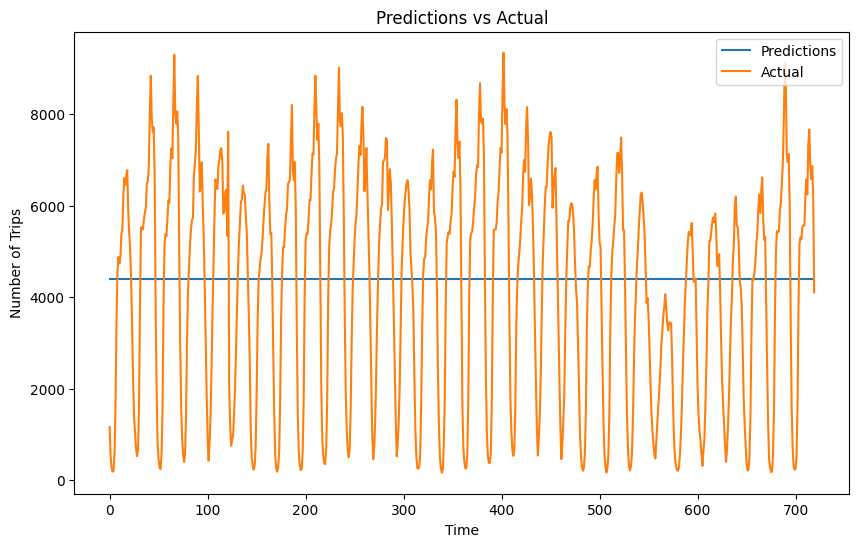

In [ ]:

max_trips = 52767
min_trips = 1
predictions = predictions * (max_trips - min_trips) + min_trips
actual_targets = []
for input_data, condition_data, output_data in test_loader:
    actual_targets.append(output_data.numpy())

# Concatenating actual target values
actual_targets = np.concatenate(actual_targets)

# Denormalize actual target values
actual_targets = actual_targets * (max_trips - min_trips) + min_trips
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='Predictions')
plt.plot(actual_targets[:, 0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()

In [ ]:
print((predictions[10]))
print((actual_targets[10]))

[4490.399  4496.847  4499.7563 4498.2847 4478.886  4498.5    4470.677
 4445.906  4419.712  4419.5425 4408.313  4409.074  4441.105  4466.313
 4465.3027 4449.031  4509.321  4489.778  4460.365  4456.3647 4427.2656
 4391.829  4413.8076 4429.194 ]
[4736.0913  4895.3877  5377.26    5467.86    6226.51    6600.857
 6447.534   6656.611   6775.0874  5880.04    5399.163   4995.944
 4334.8633  3275.5405  2149.513   1357.0122  1014.52454  685.97534
  526.6788   671.04126 1626.8208  3899.7842  5519.6313  5521.6226 ]


RNN

Epoch [10/10], Loss: 0.0056


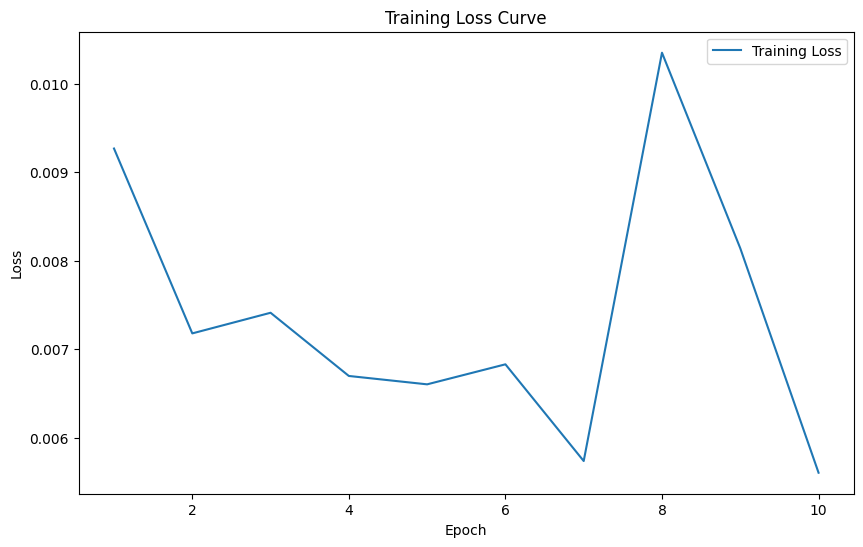

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(out[:, -1, :])
        return out, h

# Define hyperparameters
input_size = 11 # Number of features
hidden_size = 64
num_layers = 2
output_size = 24  # Output size adjusted to output 24 values for each prediction
seq_length = 24*7
learning_rate = 0.001
num_epochs = 10

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store loss values
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # Initialize epoch loss
    for input_data, condition_data, output_data in train_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        int_data = torch.cat([input_data, condition_data], dim=2).to(device)

        output_data = output_data.to(device)
        # Forward pass
        optimizer.zero_grad()
        h = torch.zeros(num_layers, input_data.size(0), hidden_size).to(device)
        output, _ = model(int_data, h)
        loss = criterion(output, output_data)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_data.size(0)  # Accumulate the loss for this batch

    # Calculate average epoch loss
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [ ]:
# Testing the model
model.eval()  # Set the model to evaluation mode
test_losses = []  # Initialize list to store test loss values

with torch.no_grad():
    predictions = []
    for input_data, condition_data, output_data in test_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        int_data = torch.cat([input_data, condition_data], dim=2).to(device)

        output_data = output_data.to(device)
        h = torch.zeros(num_layers, input_data.size(0), hidden_size).to(device)
        output, _ = model(int_data, h)
        loss = criterion(output, output_data)
        output = output.squeeze().cpu().numpy()
        predictions.append(output)
        test_losses.append(loss.item())

# Calculate average test loss
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {avg_test_loss}')

# Concatenate all predictions into a single array
predictions = np.concatenate(predictions)


Average Test Loss: 0.0006018308655863317


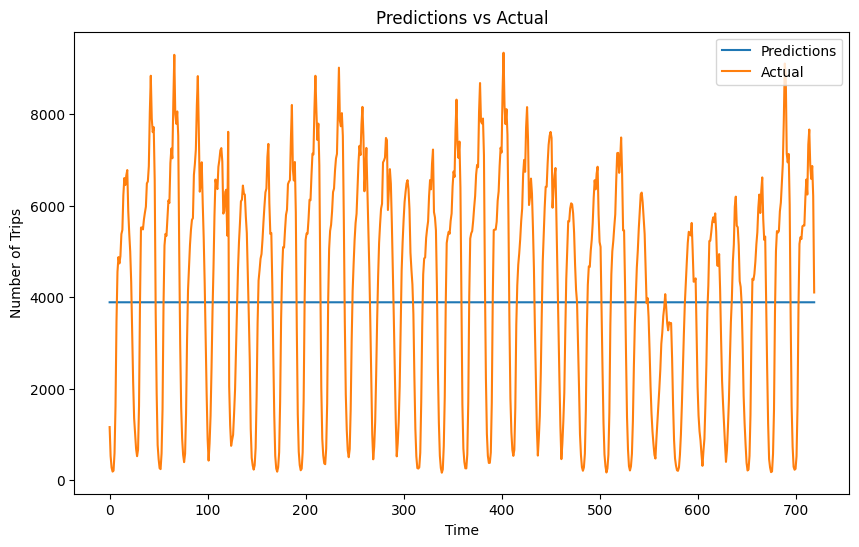

In [ ]:
max_trips = 52767
min_trips = 1
predictions = predictions * (max_trips - min_trips) + min_trips
actual_targets = []
for input_data, condition_data, output_data in test_loader:
    actual_targets.append(output_data.numpy())

# Concatenating actual target values
actual_targets = np.concatenate(actual_targets)

# Denormalize actual target values
actual_targets = actual_targets * (max_trips - min_trips) + min_trips
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='Predictions')
plt.plot(actual_targets[:, 0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()

GRU

Epoch [10/10], Loss: 0.0080


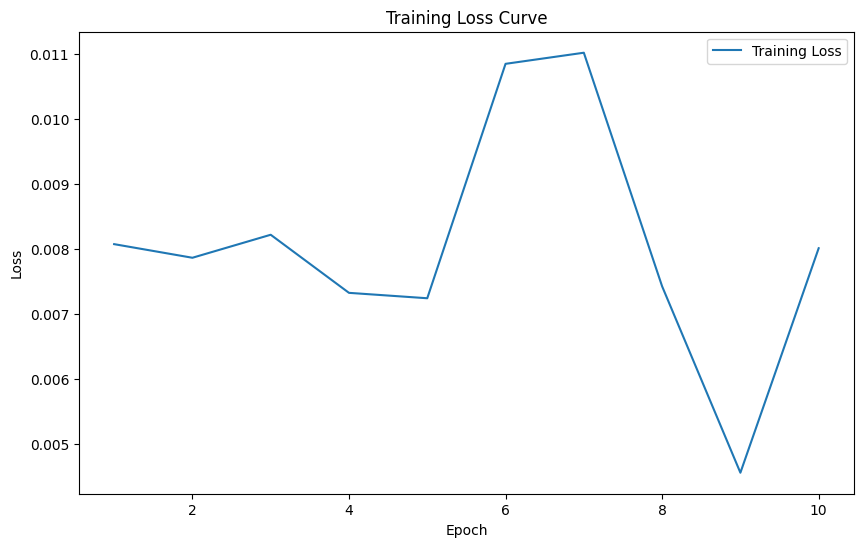

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(out[:, -1, :])
        return out, h

# Define hyperparameters
input_size = 11  # Number of features
hidden_size = 64
num_layers = 2
output_size = 24  # Output size adjusted to output 24 values for each prediction
seq_length = 24*7
learning_rate = 0.001
num_epochs = 10

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the device
model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store loss values
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # Initialize epoch loss
    for input_data, condition_data, output_data in train_loader:
        input_data = input_data.to(device)  # Move input data to the device
        condition_data = condition_data.to(device)
        int_data = torch.cat([input_data, condition_data], dim=2).to(device)

        output_data = output_data.to(device)
        # Forward pass
        optimizer.zero_grad()
        h = torch.zeros(num_layers, input_data.size(0), hidden_size).to(device)
        output, _ = model(int_data, h)
        loss = criterion(output, output_data)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_data.size(0)  # Accumulate the loss for this batch

    # Calculate average epoch loss
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
predictions = []
with torch.no_grad():  # No need to compute gradients during testing
    for input_data, condition_data, output_data in test_loader:
        input_data = input_data.to(device)  # Move input data to the device
        condition_data = condition_data.to(device)
        int_data = torch.cat([input_data, condition_data], dim=2).to(device)
        output_data = output_data.to(device)
        h = torch.zeros(num_layers, input_data.size(0), hidden_size).to(device)
        output, _ = model(int_data, h)
        loss = criterion(output, output_data)
        output = output.squeeze().cpu().numpy()
        predictions.append(output)
        test_loss += loss.item() * input_data.size(0)

# Calculate average test loss
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {avg_test_loss}')
predictions = np.concatenate(predictions)

Average Test Loss: 0.0022679559576014676


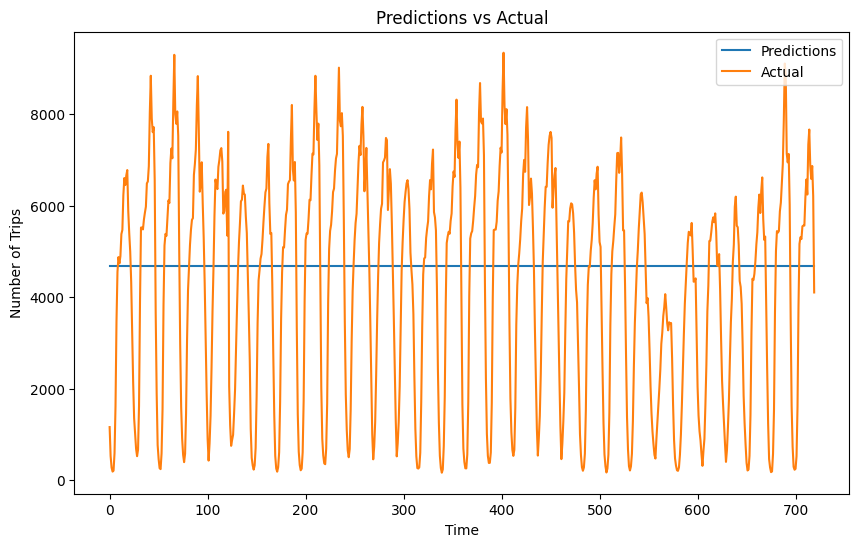

In [ ]:
max_trips = 52767
min_trips = 1
predictions = predictions * (max_trips - min_trips) + min_trips
actual_targets = []
for input_data, condition_data, output_data in test_loader:
    actual_targets.append(output_data.numpy())

# Concatenating actual target values
actual_targets = np.concatenate(actual_targets)

# Denormalize actual target values
actual_targets = actual_targets * (max_trips - min_trips) + min_trips
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='Predictions')
plt.plot(actual_targets[:, 0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()

**Transformers**


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=64, nhead=8, num_layers=6, dim_feedforward=2048, max_len=5000):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, output_size)
        self.fc = nn.Linear(24, 24)


    def forward(self, src, src_mask=None):
        src = self.input_layer(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.output_layer(output)
        output = self.fc(output[:, -1, :])
        return output

# Example usage
input_size = 7  # Number of input features
output_size = 24  # Number of output values to predict
d_model = 64  # Dimension of the model
nhead = 8  # Number of attention heads
num_layers = 6  # Number of encoder layers
dim_feedforward = 2048  # Dimension of the feedforward network

model = TransformerModel(input_size, output_size, d_model, nhead, num_layers, dim_feedforward).to(device)

In [ ]:
train_losses = []
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for input_data, condition_data, output_data in train_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        output_data = output_data.to(device)

        optimizer.zero_grad()
        output = model(input_data, src_mask=None)
        loss = criterion(output, output_data)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_data.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/10], Loss: 0.0128


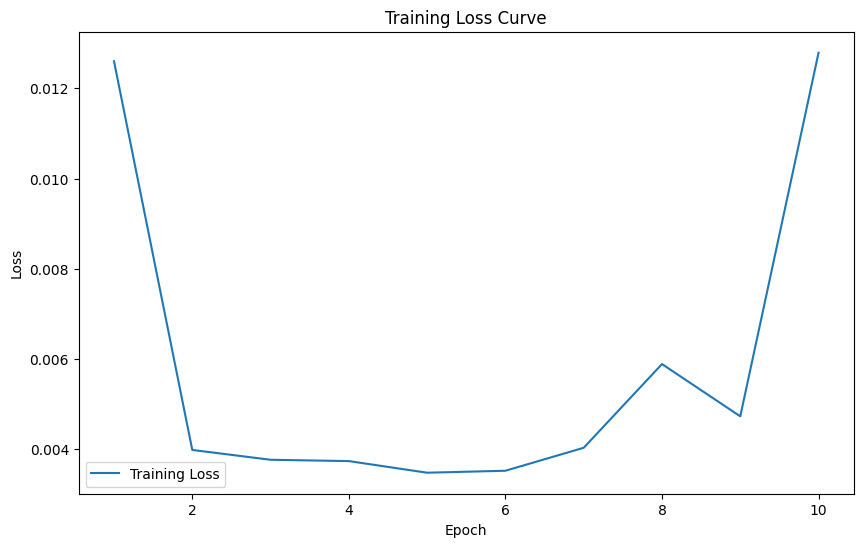

In [ ]:
# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Evaluation
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for input_data, condition_data, output_data in test_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        output_data = output_data.to(device)
        output = model(input_data, src_mask=None)

        # Calculate loss
        loss = criterion(output, output_data)

        # Accumulate the test loss
        test_loss += loss.item() * input_data.size(0)

        # Convert output to numpy array and append to predictions list
        output = output.squeeze().cpu().numpy()
        predictions.append(output)

# Average test loss
test_loss /= len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')

predictions = np.concatenate(predictions)

max_trips = 52767
min_trips = 1
predictions = predictions * (max_trips - min_trips) + min_trips
actual_targets = []
for input_data, condition_data, output_data in test_loader:
    actual_targets.append(output_data.numpy())

# Concatenating actual target values
actual_targets = np.concatenate(actual_targets)

# Denormalize actual target values
actual_targets = actual_targets * (max_trips - min_trips) + min_trips

Test Loss: 0.0021


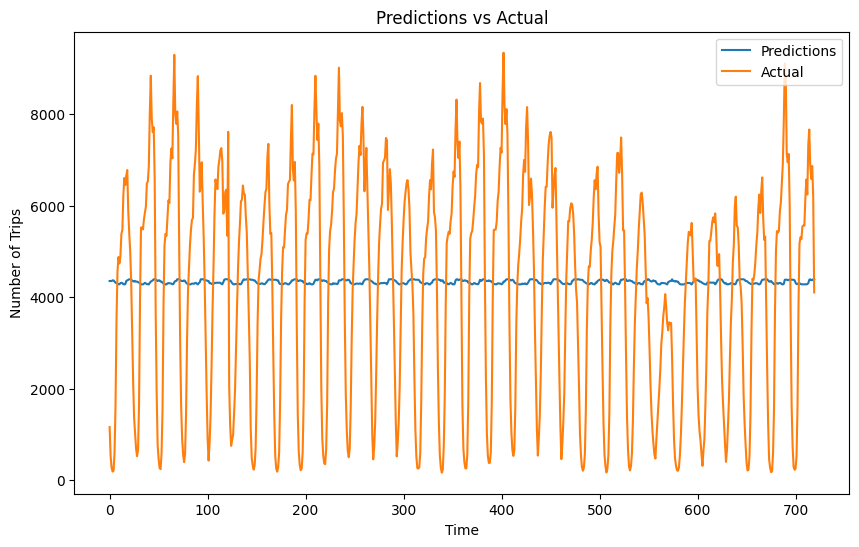

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='Predictions')
plt.plot(actual_targets[:, 0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()

In [ ]:
df = pd.read_parquet("/kaggle/input/dl-tier/normalised_data.parquet")
class DateTimeEncoder:
    def __init__(self):
        self.date_mapping = {}
        self.day_mapping = {}
        self.month_mapping = {}
        self.hour_mapping = {}

    def fit(self, datetime_column):
        # Create a mapping of datetime values to ordinal numbers
        unique_dates = sorted(datetime_column.dt.date.unique())
        unique_days = sorted(datetime_column.dt.day.unique())
        unique_months = sorted(datetime_column.dt.month.unique())
        unique_hours = sorted(datetime_column.dt.hour.unique())

        self.date_mapping = {date: i+1 for i, date in enumerate(unique_dates)}
        self.day_mapping = {day: i+1 for i, day in enumerate(unique_days)}
        self.month_mapping = {month: i+1 for i, month in enumerate(unique_months)}
        self.hour_mapping = {hour: i+1 for i, hour in enumerate(unique_hours)}

    def transform(self, datetime_column):
        # Transform datetime values to ordinal numbers using the mapping
        encoded_date = datetime_column.dt.date.map(self.date_mapping)
        encoded_day = datetime_column.dt.day.map(self.day_mapping)
        encoded_month = datetime_column.dt.month.map(self.month_mapping)
        encoded_hour = datetime_column.dt.hour.map(self.hour_mapping)
        return encoded_date, encoded_day, encoded_month, encoded_hour

    def inverse_transform(self, encoded_date, encoded_day, encoded_month, encoded_hour):
        # Retrieve the original datetime values from the encoded numbers
        decoded_date = encoded_date.map({v: k for k, v in self.date_mapping.items()})
        decoded_day = encoded_day.map({v: k for k, v in self.day_mapping.items()})
        decoded_month = encoded_month.map({v: k for k, v in self.month_mapping.items()})
        decoded_hour = encoded_hour.map({v: k for k, v in self.hour_mapping.items()})
        return decoded_date, decoded_day, decoded_month, decoded_hour

    # Initialize and fit the encoder
encoder = DateTimeEncoder()
encoder.fit(df['time'])

# Encode datetime values
df['encoded_date'], df['day'], df['month'], df['hour'] = encoder.transform(df['time'])
# Decode ordinal numbers back to datetime values
# decoded_date, decoded_day, decoded_month = encoder.inverse_transform(encoded_date, encoded_day, encoded_month)

data = df.drop(['time'], axis=1)
data.head()


def unnormalize_data(df, column, max_value):
        df[column] = df[column] * (max_value - df[column].min()) + df[column].min()
        return df[column]

max_values = [600*1e3,50,35,100*1e3,100*1e3,10,53*1e3]

lstm_data = data.iloc[:,:7]
output_data = data.iloc[:,7]
condition_data=data.iloc[:,8:]

# Define a function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return sequences

class TimeSeriesDataset(Dataset):
    def __init__(self, data_input, data_condition, data_output, input_seq_length, output_seq_length):
        self.sequences_output = create_sequences(data_output, output_seq_length)
        self.sequences_input = create_sequences(data_input, input_seq_length)[:len(self.sequences_output)]
        self.sequences_condition = create_sequences(data_condition, input_seq_length)[:len(self.sequences_output)]

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences_input[idx], dtype=torch.float32),
            torch.tensor(self.sequences_condition[idx], dtype=torch.float32),
            torch.tensor(self.sequences_output[idx], dtype=torch.float32)
        )



input_seq_length = 24*7  # Set the input sequence length
output_seq_length = 24
dataset = TimeSeriesDataset(lstm_data.values,condition_data.values, output_data.values[168:], input_seq_length, output_seq_length)


train_dataset = dataset[:-30*24]
test_dataset = dataset[-30*24:]
train_dataset = list(zip(*train_dataset)) #transpose (3,n) tuple to (n,3)
test_dataset = list(zip(*test_dataset))

# Convert train dataset to DataLoader
train_loader = DataLoader(train_dataset, batch_size=64)

# # Convert test dataset to DataLoader
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=64, nhead=8, num_layers=6, dim_feedforward=2048, max_len=5000):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, output_size)
        self.fc = nn.Linear(24, 24)


    def forward(self, src, src_mask=None):
        src = self.input_layer(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.output_layer(output)
#         output =  # Remove the sequence length dimension
        output = self.fc(output[:, -1, :])
        return output

# Example usage
input_size = 11  # Number of input features
output_size = 24  # Number of output values to predict
d_model = 64  # Dimension of the model
nhead = 8  # Number of attention heads
num_layers = 6  # Number of encoder layers
dim_feedforward = 2048  # Dimension of the feedforward network

model = TransformerModel(input_size, output_size, d_model, nhead, num_layers, dim_feedforward).to(device)


In [ ]:
train_losses = []
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for input_data, condition_data, output_data in train_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        int_data= torch.concat([input_data, condition_data], axis = 2).to(device)
        output_data = output_data.to(device)

        optimizer.zero_grad()
        output = model(int_data, src_mask=None)
        loss = criterion(output, output_data)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_data.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/10], Loss: 0.0145


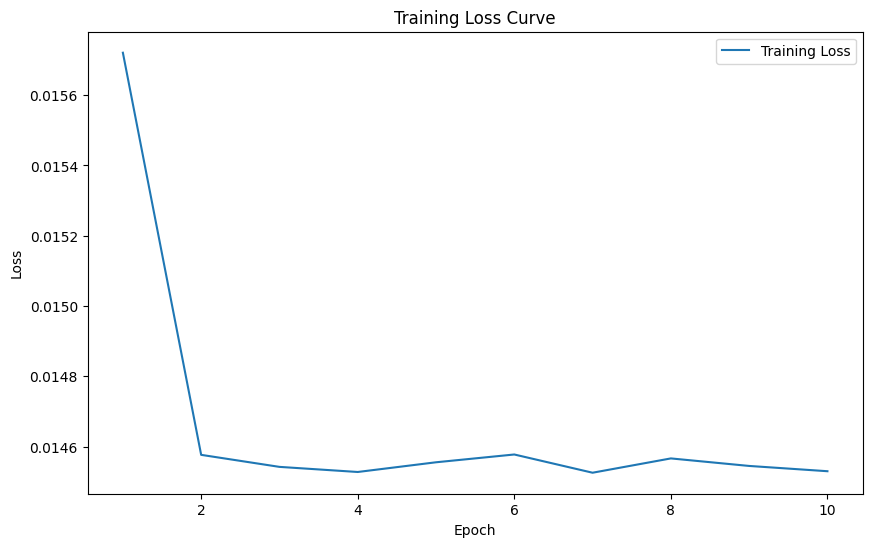

In [ ]:
# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Evaluation
model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for input_data, condition_data, output_data in test_loader:
        input_data = input_data.to(device)
        condition_data = condition_data.to(device)
        int_data= torch.concat([input_data, condition_data], axis = 2).to(device)
        output_data = output_data.to(device)
        output = model(int_data, src_mask=None)

        # Calculate loss
        loss = criterion(output, output_data)

        # Accumulate the test loss
        test_loss += loss.item() * input_data.size(0)

        # Convert output to numpy array and append to predictions list
        output = output.squeeze().cpu().numpy()
        predictions.append(output)

# Average test loss
test_loss /= len(test_loader.dataset)

print(f'Test Loss: {test_loss}')

predictions = np.concatenate(predictions)

max_trips = 52767
min_trips = 1
predictions = predictions * (max_trips - min_trips) + min_trips
actual_targets = []
for input_data, condition_data, output_data in test_loader:
    actual_targets.append(output_data.numpy())

# Concatenating actual target values
actual_targets = np.concatenate(actual_targets)

# Denormalize actual target values
actual_targets = actual_targets * (max_trips - min_trips) + min_trips

Test Loss: 0.002221572068002489


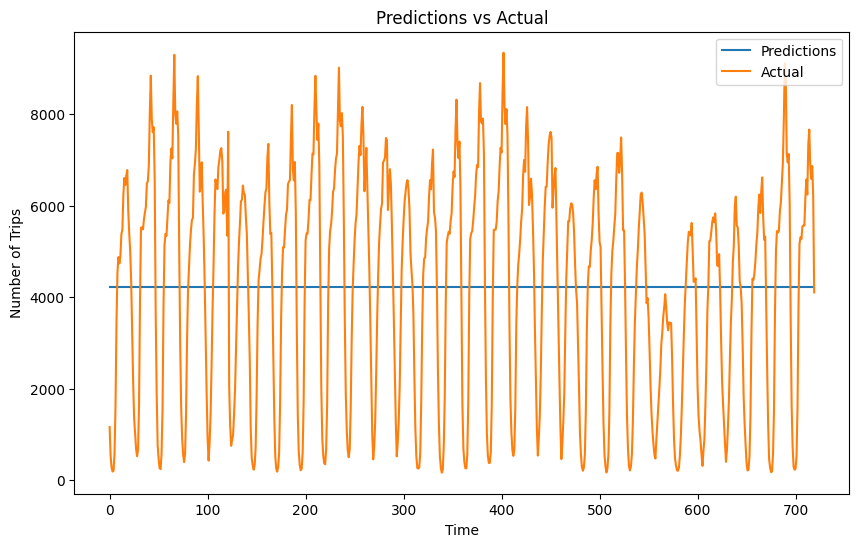

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='Predictions')
plt.plot(actual_targets[:, 0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()